In [11]:
from google.colab import drive
drive.mount('/content/Drive')

Drive already mounted at /content/Drive; to attempt to forcibly remount, call drive.mount("/content/Drive", force_remount=True).


In [158]:
# Install required packages
!pip install fairlearn python-Levenshtein geopandas shapely tqdm dask distributed xgboost shap folium pandas numpy matplotlib seaborn scikit-learn ucimlrepo memory_profiler joblib

In [167]:
# Import libraries
import os
import re
import time
import logging
import gc
import warnings
import requests
import pandas as pd
import numpy as np
from typing import Optional, Dict, List, Tuple, Any, Union
from dataclasses import dataclass
from pathlib import Path
from tqdm.notebook import tqdm # Use tqdm.notebook for Colab

# For chunk-based CSV reading/writing
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from fuzzywuzzy import process

# Data sources
from ucimlrepo import fetch_ucirepo

# Machine learning
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import shap

# Fairness metrics - will be imported conditionally
try:
    from fairlearn.metrics import demographic_parity_difference, equalized_odds_difference
    from fairlearn.postprocessing import ThresholdOptimizer
    FAIRLEARN_AVAILABLE = True
except ImportError:
    FAIRLEARN_AVAILABLE = False
    print("Fairlearn package not available. Fairness metrics will be disabled.")

# For geographic analysis
import folium
from folium.plugins import HeatMap, MarkerCluster
try:
    from google.colab import output
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

# Display settings for better readability
pd.set_option('display.max_columns', 50)
pd.set_option('display.expand_frame_repr', False)
plt.rcParams['figure.figsize'] = [12, 8]
plt.style.use('ggplot')
warnings.filterwarnings('ignore')

In [168]:
# Configuration class
@dataclass
class Config:
    data_dir: str = "data"
    max_crime_records: int = 6000000  # Set to 6 million records
    crime_batch_size: int = 100000    # Batch size for API requests
    crime_pause: float = 0.5          # Pause between API requests
    target: str = "Crime Rate"
    missing_threshold: float = 0.70   # Drop columns >70% missing
    correlation_threshold: float = 0.95  # Drop features if |corr|>0.95
    dask_blocksize: str = "64MB"      # Block size for chunked reading
    target_npartitions: int = 100     # Partitions for distributed processing
    cache_results: bool = True        # Whether to use cached results
    random_state: int = 42            # For reproducibility
    test_size: float = 0.2            # Test split size
    use_sample_for_analysis: bool = True  # Use sample for analysis
    analysis_sample_size: int = 100000  # Sample size for analysis
    eda_sample_size: int = 10000      # Sample size for EDA
    model_sample_size: int = 500000   # Sample size for modeling
    verbose: int = 1                  # Verbosity level
    sensitive_attributes: List[str] = None  # Attributes to check for bias

    def __post_init__(self):
        if self.sensitive_attributes is None:
            # Default sensitive attributes to check for bias
            self.sensitive_attributes = [
                "racepctblack",
                "racePctWhite",
                "racePctAsian",
                "racePctHisp",
                "pctWPubAsst",
                "medIncome"
            ]

# Create config instance
CONFIG = Config()

# Create data directory if it doesn't exist
os.makedirs(CONFIG.data_dir, exist_ok=True)

In [169]:
# Memory management functions
def get_memory_usage():
    """Get current memory usage in MB"""
    import psutil
    process = psutil.Process(os.getpid())
    memory_info = process.memory_info()
    memory_mb = memory_info.rss / (1024 * 1024)
    return memory_mb

def print_memory_usage(label="Current memory usage"):
    """Print current memory usage with a label"""
    memory_mb = get_memory_usage()
    print(f"{label}: {memory_mb:.2f} MB")

def clear_memory(aggressive=False):
    """Clear memory by forcing garbage collection"""
    import gc

    # Get memory before cleanup
    before_mb = get_memory_usage()

    # Run garbage collection
    gc.collect()

    if aggressive:
        # Run multiple passes for aggressive cleanup
        for _ in range(2):
            gc.collect()

        # Force Python to release memory to OS if possible (on Linux)
        try:
            import ctypes
            libc = ctypes.CDLL('libc.so.6')
            libc.malloc_trim(0)
        except:
            pass

    # Get memory after cleanup
    after_mb = get_memory_usage()
    freed_mb = before_mb - after_mb

    print(f"Memory cleanup: {freed_mb:.2f} MB freed")
    return freed_mb

In [170]:
# Set up logger
def setup_logger(name: str = __name__, level: int = logging.INFO) -> logging.Logger:
    """Set up a logger with a consistent format."""
    logger = logging.getLogger(name)

    # Avoid adding handlers if they already exist
    if not logger.handlers:
        logger.setLevel(level)

        # Create handler
        handler = logging.StreamHandler()
        handler.setLevel(level)

        # Create formatter
        formatter = logging.Formatter("%(asctime)s [%(levelname)s] %(message)s")
        handler.setFormatter(formatter)

        # Add handler to logger
        logger.addHandler(handler)

    return logger

logger = setup_logger()

In [171]:
# Data type optimization function
def downcast_dtypes(df: pd.DataFrame) -> pd.DataFrame:
    """Downcast numeric columns to reduce memory usage."""
    if df.empty:
        return df

    # Track memory usage before optimization
    start_mem = df.memory_usage(deep=True).sum() / (1024 * 1024)

    # Create a copy to avoid modifying the original DataFrame
    result = df.copy()

    # Optimize float columns
    float_cols = result.select_dtypes(include=['float', 'float64', 'float32']).columns
    for col in float_cols:
        # Use float32 for all float columns
        result[col] = result[col].astype(np.float32)

    # Optimize integer columns
    int_cols = result.select_dtypes(include=['int', 'int64', 'int32']).columns
    for col in int_cols:
        col_min = result[col].min()
        col_max = result[col].max()

        # Choose smallest possible integer type based on range
        if col_min >= 0:
            if col_max < 256:
                result[col] = result[col].astype(np.uint8)
            elif col_max < 65536:
                result[col] = result[col].astype(np.uint16)
            else:
                result[col] = result[col].astype(np.uint32)
        else:
            if col_min > -128 and col_max < 128:
                result[col] = result[col].astype(np.int8)
            elif col_min > -32768 and col_max < 32768:
                result[col] = result[col].astype(np.int16)
            else:
                result[col] = result[col].astype(np.int32)

    # Optimize categorical columns
    obj_cols = result.select_dtypes(include=['object']).columns
    for col in obj_cols:
        # Convert to category if column has few unique values
        nunique = result[col].nunique()
        if nunique < len(result) * 0.5:  # If fewer than 50% unique values
            result[col] = result[col].astype('category')

    # Calculate memory savings
    end_mem = result.memory_usage(deep=True).sum() / (1024 * 1024)
    print(f"Memory optimized: {start_mem:.2f} MB → {end_mem:.2f} MB ({100 * (start_mem - end_mem) / start_mem:.1f}% reduction)")

    return result

In [172]:
# Optimized data loading functions
def load_csv(filename: str, columns: Optional[List[str]] = None, nrows: Optional[int] = None) -> Optional[pd.DataFrame]:
    """
    Load a CSV from data_dir with improved memory efficiency.

    Parameters:
    -----------
    filename : str
        Name of the CSV file to load
    columns : list, optional
        Specific columns to load (reduces memory)
    nrows : int, optional
        Number of rows to load (useful for sampling)
    """
    path = os.path.join(CONFIG.data_dir, filename)
    if not os.path.exists(path):
        return None

    try:
        # Calculate file size for better decision making
        file_size = os.path.getsize(path) / (1024*1024)
        print(f"Loading '{filename}' ({file_size:.2f} MB)")

        # For large files, use Dask with optimized settings
        if file_size > 1e9:  # If file is larger than 1GB
            print(f"Using Dask for large file processing...")

            # Create optimized read configuration
            read_opts = {
                'blocksize': CONFIG.dask_blocksize,
                'assume_missing': True,
                'na_values': ['?', 'NA', 'NULL', ''],
                'low_memory': False,
            }

            # Add column selection if specified
            if columns is not None:
                read_opts['usecols'] = columns

            # Process with Dask
            ddf = dd.read_csv(path, **read_opts)

            # Apply row limit if needed
            if nrows is not None:
                ddf = ddf.head(nrows, compute=False)

            # Compute final DataFrame
            df = ddf.compute()
        else:
            # For smaller files, use pandas
            read_opts = {
                'low_memory': False,
                'na_values': ['?', 'NA', 'NULL', ''],
            }

            # Add column selection if specified
            if columns is not None:
                read_opts['usecols'] = columns

            # Add row limit if specified
            if nrows is not None:
                read_opts['nrows'] = nrows

            # Read the file
            df = pd.read_csv(path, **read_opts)

        print(f"Loaded '{filename}' with shape {df.shape}")

        # Apply memory optimization after loading
        df = downcast_dtypes(df)

        return df
    except Exception as e:
        print(f"Error loading '{filename}': {str(e)}")
        return None

def save_parquet(df: pd.DataFrame, filename: str) -> None:
    """Save a DataFrame to Parquet format for more efficient storage."""
    path = os.path.join(CONFIG.data_dir, filename)

    # Calculate data size for reporting
    mem_usage = df.memory_usage(deep=True).sum() / (1024 * 1024)
    print(f"Saving DataFrame ({mem_usage:.2f} MB) to '{filename}'...")

    # For large DataFrames, use Dask to write in chunks
    if len(df) > 1e6:  # If more than 1 million rows
        print(f"Using Dask for large DataFrame...")
        ddf = dd.from_pandas(df, npartitions=CONFIG.target_npartitions)
        ddf.to_parquet(path, engine="pyarrow", compression="snappy")
    else:
        # Standard pandas save for smaller DataFrames
        df.to_parquet(path, engine="pyarrow", compression="snappy")

    # Report file size after saving
    if os.path.exists(path):
        file_size = os.path.getsize(path) / (1024 * 1024)
        print(f"Saved '{filename}' with shape {df.shape}, file size: {file_size:.2f} MB")

In [173]:
def remove_dict_columns(df: pd.DataFrame) -> pd.DataFrame:
    """Convert any dict-valued columns to strings."""
    # Create a copy to avoid modifying the original DataFrame
    result = df.copy()

    for col in result.columns:
        if result[col].dtype == 'object' and result[col].dropna().size > 0:
            sample = result[col].dropna().iloc[0]
            if isinstance(sample, dict):
                print(f"Converting column '{col}' from dict to string.")
                result[col] = result[col].apply(lambda x: str(x) if isinstance(x, dict) else x)

    return result

def drop_duplicates_and_strip(df: pd.DataFrame, key_col: str) -> pd.DataFrame:
    """Drop duplicates and strip whitespace from key column."""
    # Create a copy to avoid modifying the original DataFrame
    result = df.copy()

    # Drop duplicates
    result = result.drop_duplicates()

    # Clean key column if it exists
    if key_col in result.columns:
        # Handle missing values before string operations
        result = result[result[key_col].notna()]
        result[key_col] = result[key_col].astype(str).str.strip()

    return result

def impute_missing(df: pd.DataFrame) -> pd.DataFrame:
    """
    Handle missing values: drop high-missing columns and impute remaining.
    """
    # Create a copy to avoid modifying the original DataFrame
    result = df.copy()

    # 1) Drop columns with missing ratio > threshold
    missing_ratio = result.isnull().mean()
    to_drop = missing_ratio[missing_ratio > CONFIG.missing_threshold].index
    if len(to_drop) > 0:
        print(f"Dropping columns (>{CONFIG.missing_threshold*100}% missing): {list(to_drop)}")
        result = result.drop(columns=to_drop)

    # 2) Downcast before imputation (optional, for memory)
    result = downcast_dtypes(result)

    # 3) Impute numeric columns (median) & categorical (mode)
    numeric_cols = result.select_dtypes(include=[np.number]).columns
    cat_cols = result.select_dtypes(include=['object']).columns

    # Impute numeric columns
    for c in numeric_cols:
        if result[c].isnull().any():
            median_val = result[c].median()
            # Avoid FutureWarning by not using inplace
            result[c] = result[c].fillna(median_val)

    # Impute categorical columns
    for c in cat_cols:
        if result[c].isnull().any():
            mode_val = result[c].mode(dropna=True)
            fill_val = mode_val.iloc[0] if not mode_val.empty else "unknown"
            # Avoid FutureWarning by not using inplace
            result[c] = result[c].fillna(fill_val)

    return result

In [174]:
def setup_dask_client():
    """Set up an optimized Dask client."""
    import psutil

    # Calculate resources
    total_memory = psutil.virtual_memory().total
    logical_cpu = psutil.cpu_count(logical=True)

    # Set worker count and memory
    if total_memory < 8 * (1024 ** 3):  # Less than 8GB
        n_workers = max(1, logical_cpu // 2)
    else:
        n_workers = max(2, logical_cpu - 2)  # Leave some cores

    memory_per_worker = int(total_memory * 0.7) // n_workers  # Use 70% of RAM
    memory_per_worker_gb = memory_per_worker / (1024 ** 3)

    print(f"Setting up Dask with {n_workers} workers, each with {memory_per_worker_gb:.1f}GB memory")

    # Create a LocalCluster with optimized settings
    cluster = LocalCluster(
        n_workers=n_workers,
        threads_per_worker=2,
        memory_limit=f"{memory_per_worker_gb}GB",
        processes=True,
    )

    client = Client(cluster)
    print(f"Dask dashboard: {client.dashboard_link}")

    return client

In [175]:
def fetch_chicago_crime_data() -> pd.DataFrame:
    """
    Fetch Chicago Crime Data from the SODA API, up to max_crime_records.
    """
    cache_file = "chicago_crime_data.csv"
    parquet_cache = "chicago_crime_data.parquet"

    # Try to load from cached parquet first
    parquet_path = os.path.join(CONFIG.data_dir, parquet_cache)
    if CONFIG.cache_results and os.path.exists(parquet_path):
        print(f"Loading cached parquet data from {parquet_cache}...")
        df = pd.read_parquet(parquet_path)
        print(f"Loaded cached data with shape {df.shape}")
        return df

    # Then try from CSV
    if CONFIG.cache_results:
        df_cached = load_csv(cache_file)
        if df_cached is not None:
            # Convert to parquet for future use
            save_parquet(df_cached, parquet_cache)
            return df_cached

    print("Fetching Chicago Crime Data from API...")
    print(f"Target: {CONFIG.max_crime_records:,} records in batches of {CONFIG.crime_batch_size:,}")

    SODA_CRIME_URL = "https://data.cityofchicago.org/resource/ijzp-q8t2.json"
    offset = 0
    all_data = []

    # Initialize progress bar for API fetching
    pbar = tqdm(total=CONFIG.max_crime_records, desc="Fetching crime data")

    # For large datasets, save intermediate results
    temp_dfs = []
    temp_df_counter = 0

    try:
        while True:
            params = {"$limit": CONFIG.crime_batch_size, "$offset": offset}

            try:
                resp = requests.get(SODA_CRIME_URL, params=params, timeout=30)
                resp.raise_for_status()
            except Exception as ex:
                print(f"Error fetching crime data at offset {offset}: {ex}")
                if all_data or temp_dfs:
                    break  # Use what we have
                else:
                    raise

            batch = resp.json()
            if not batch:
                print("No more crime data returned by the API.")
                break

            all_data.extend(batch)
            offset += CONFIG.crime_batch_size

            # Update progress bar
            pbar.update(len(batch))
            pbar.set_postfix({"Total": len(all_data)})

            # For large datasets, periodically save to disk
            if len(all_data) >= 500000:  # Save every 500K records
                print(f"Saving intermediate batch of {len(all_data):,} records...")
                temp_df = pd.DataFrame(all_data)
                temp_df_path = os.path.join(CONFIG.data_dir, f"temp_crime_data_{temp_df_counter}.parquet")
                save_parquet(temp_df, f"temp_crime_data_{temp_df_counter}.parquet")
                temp_dfs.append(temp_df_path)
                temp_df_counter += 1
                all_data = []  # Clear memory
                clear_memory()

            if offset >= CONFIG.max_crime_records:
                print(f"Reached maximum record limit of {CONFIG.max_crime_records:,}.")
                break

            time.sleep(CONFIG.crime_pause)

    except KeyboardInterrupt:
        print("Fetch interrupted by user. Using data collected so far.")

    finally:
        pbar.close()

    # Process final batch if any
    if all_data:
        temp_df = pd.DataFrame(all_data)
        temp_df_path = os.path.join(CONFIG.data_dir, f"temp_crime_data_{temp_df_counter}.parquet")
        save_parquet(temp_df, f"temp_crime_data_{temp_df_counter}.parquet")
        temp_dfs.append(temp_df_path)
        all_data = []  # Clear memory

    # Combine temp dataframes if any
    if temp_dfs:
        print(f"Combining {len(temp_dfs)} temporary dataframes...")
        ddf = dd.read_parquet(temp_dfs)
        df = ddf.compute()

        # Process the dataframe
        df = remove_dict_columns(df)
        df = drop_duplicates_and_strip(df, "community_area")
        df = impute_missing(df)

        # Clean up temp files
        for temp_file in temp_dfs:
            if os.path.exists(temp_file):
                os.remove(temp_file)
    else:
        df = pd.DataFrame(all_data)
        df = remove_dict_columns(df)
        df = drop_duplicates_and_strip(df, "community_area")
        df = impute_missing(df)

    print(f"Final shape of Chicago Crime data: {df.shape}")

    # Save results if caching enabled
    if CONFIG.cache_results:
        save_parquet(df, parquet_cache)

    return df

def fetch_chicago_community_data() -> pd.DataFrame:
    """Fetch Chicago Community Areas data from the SODA API."""
    cache_file = "chicago_community_data.csv"

    if CONFIG.cache_results:
        df_cached = load_csv(cache_file)
        if df_cached is not None:
            return df_cached

    print("Fetching Chicago Community Areas Data from API...")

    SODA_COMMUNITY_URL = "https://data.cityofchicago.org/resource/igwz-8jzy.json"

    try:
        resp = requests.get(SODA_COMMUNITY_URL, timeout=10)
        resp.raise_for_status()
    except Exception as ex:
        print(f"Error fetching community data: {ex}")
        raise

    df = pd.DataFrame(resp.json())
    df = remove_dict_columns(df)
    df = drop_duplicates_and_strip(df, "area_numbe")
    df = impute_missing(df)

    print(f"Final shape of Community data: {df.shape}")

    if CONFIG.cache_results:
        save_parquet(df, "chicago_community_data.parquet")

    return df

def fetch_uci_data() -> pd.DataFrame:
    """Fetch UCI Communities & Crime dataset."""
    cache_file = "uci_communities_crime.parquet"

    if CONFIG.cache_results:
        parquet_path = os.path.join(CONFIG.data_dir, cache_file)
        if os.path.exists(parquet_path):
            print(f"Loading cached UCI data from {cache_file}...")
            df = pd.read_parquet(parquet_path)
            print(f"Loaded UCI data with shape {df.shape}")
            return df

    print("Fetching UCI Communities and Crime dataset...")

    try:
        dataset = fetch_ucirepo(id=183)
    except Exception as ex:
        print(f"Error fetching UCI dataset: {ex}")
        raise

    df = pd.DataFrame(dataset.data.features)
    df[CONFIG.target] = dataset.data.targets

    # Clean data
    df = df.drop_duplicates()

    if "communityname" in df.columns:
        df["communityname"] = df["communityname"].astype(str).str.strip()
        df["communityname_clean"] = df["communityname"].apply(
            lambda x: re.sub(r'[\W_]+', '', x.lower())
        )

    df = impute_missing(df)

    print(f"Final shape of UCI data: {df.shape}")

    if CONFIG.cache_results:
        save_parquet(df, cache_file)

    return df

In [176]:
def create_mapping(community_df: pd.DataFrame) -> pd.DataFrame:
    """Create a mapping from community area number to neighborhood."""
    mapping_df = community_df[['area_numbe', 'community']].copy()
    mapping_df.rename(columns={
        'area_numbe': 'community_area',
        'community': 'mapped_neighborhood'
    }, inplace=True)

    mapping_df["community_area"] = mapping_df["community_area"].astype(str).str.strip()

    # Clean neighborhood text for better matching
    mapping_df["mapped_neighborhood"] = mapping_df["mapped_neighborhood"].apply(
        lambda x: re.sub(r'[\W_]+', '', str(x).lower()) if pd.notnull(x) else x
    )

    print("Mapping DataFrame created:")
    display(mapping_df.head())

    return mapping_df

def merge_crime_and_mapping(crime_df: pd.DataFrame, mapping_df: pd.DataFrame) -> pd.DataFrame:
    """Merge crime data with community mapping."""
    if "community_area" not in crime_df.columns:
        raise KeyError("community_area column not found in Crime data.")

    # Create a copy to avoid modifying the original DataFrame
    crime_df_copy = crime_df.copy()
    crime_df_copy["community_area"] = crime_df_copy["community_area"].astype(str).str.strip()

    # For large datasets, use Dask
    if len(crime_df_copy) > 1e6:
        print("Using Dask for large dataframe merge...")

        # Set up Dask client if not already running
        try:
            from dask.distributed import get_client
            client = get_client()
        except ValueError:
            client = setup_dask_client()

        ddf_crime = dd.from_pandas(crime_df_copy, npartitions=CONFIG.target_npartitions)
        ddf_mapping = dd.from_pandas(mapping_df, npartitions=max(1, len(mapping_df) // 1000))

        merged_ddf = ddf_crime.merge(ddf_mapping, on="community_area", how="left")
        merged = merged_ddf.compute()
    else:
        merged = crime_df_copy.merge(mapping_df, on="community_area", how="left")

    print(f"Merged Crime + Community shape: {merged.shape}")

    return merged

def optimized_fuzzy_match_and_merge(
    merged_crime: pd.DataFrame,
    uci_df: pd.DataFrame,
    mapping_df: pd.DataFrame,
    cutoff: int = 80
) -> pd.DataFrame:
    """
    Optimized fuzzy matching between community names.
    """
    import pickle

    final_cache = "final_merged_dataset.parquet"
    cache_path = os.path.join(CONFIG.data_dir, "fuzzy_match_cache.pkl")

    # Try to load from cache first
    if CONFIG.cache_results:
        parquet_path = os.path.join(CONFIG.data_dir, final_cache)
        if os.path.exists(parquet_path):
            print(f"Loading cached final merged data...")
            df = pd.read_parquet(parquet_path)
            print(f"Loaded merged data with shape {df.shape}")
            return df

    print("Performing fuzzy matching between community names...")

    # Get clean neighborhood names
    mapped_list = mapping_df["mapped_neighborhood"].dropna().unique().tolist()

    # Check for cached matches
    matching_dict = {}
    if os.path.exists(cache_path):
        try:
            with open(cache_path, 'rb') as f:
                matching_dict = pickle.load(f)
            print(f"Loaded {len(matching_dict)} cached fuzzy matches")
        except Exception as e:
            print(f"Error loading fuzzy match cache: {e}")

    # Identify names needing matching
    all_names = uci_df["communityname_clean"].tolist()
    names_to_match = [name for name in all_names if name not in matching_dict]

    if names_to_match:
        print(f"Fuzzy matching {len(names_to_match)} new community names...")

        # Process in batches for better performance
        for name in tqdm(names_to_match, desc="Fuzzy matching"):
            match_result = process.extractOne(name, mapped_list, score_cutoff=cutoff)
            matching_dict[name] = match_result[0] if match_result else None

        # Save the updated cache
        try:
            with open(cache_path, 'wb') as f:
                pickle.dump(matching_dict, f)
        except Exception as e:
            print(f"Error saving fuzzy match cache: {e}")

    # Apply matches to UCI dataframe
    uci_df["matched_neighborhood"] = uci_df["communityname_clean"].map(matching_dict)

    # Report match statistics
    match_count = uci_df["matched_neighborhood"].notna().sum()
    total_count = len(uci_df)
    print(f"Fuzzy matching matched {match_count}/{total_count} communities ({match_count/total_count:.1%})")

    # Memory optimization before merge
    print("Optimizing DataFrames for merge...")
    merged_crime = downcast_dtypes(merged_crime)
    uci_df = downcast_dtypes(uci_df)

    # Perform the merge
    print("Performing final merge...")
    # Use Dask for large datasets
    if len(merged_crime) > 1e6:
        print("Using Dask for large dataframe merge...")

        # Set up client if needed
        try:
            from dask.distributed import get_client
            client = get_client()
        except ValueError:
            client = setup_dask_client()

        ddf_crime = dd.from_pandas(merged_crime, npartitions=CONFIG.target_npartitions)
        ddf_uci = dd.from_pandas(uci_df, npartitions=max(1, len(uci_df) // 1000))

        # Perform merge
        final_ddf = ddf_crime.merge(
            ddf_uci,
            left_on="mapped_neighborhood",
            right_on="matched_neighborhood",
            how="left",
            suffixes=("", "_uci")
        )

        # Compute result
        final_df = final_ddf.compute()
    else:
        # Standard pandas merge
        final_df = merged_crime.merge(
            uci_df,
            left_on="mapped_neighborhood",
            right_on="matched_neighborhood",
            how="left",
            suffixes=("", "_uci")
        )

    # Analyze merge results
    match_pct = final_df[CONFIG.target].notna().mean() * 100
    print(f"After merging, {match_pct:.1f}% of records have a crime rate")

    # Handle missing values from merge
    final_df = impute_missing(final_df)

    print(f"Final merged shape: {final_df.shape}")

    # Save result
    if CONFIG.cache_results:
        save_parquet(final_df, final_cache)

    return final_df

In [177]:
def detect_data_leakage(X_train, X_test, y_train, y_test, threshold=0.95):
    """
    Detect potential data leakage by identifying features that are too predictive.
    """
    import warnings
    warnings.filterwarnings('ignore', category=RuntimeWarning)

    print("Checking for potential data leakage...")

    leakage_detected = False
    suspicious_features = []
    feature_correlations = {}

    # Check for target-feature correlation in train set
    for col in X_train.columns:
        # Calculate correlation with target
        try:
            correlation = abs(np.corrcoef(X_train[col].values, y_train.values)[0, 1])
            feature_correlations[col] = correlation

            # Flag suspiciously high correlations
            if correlation > threshold:
                suspicious_features.append((col, correlation))
                leakage_detected = True
                print(f"WARNING: Suspiciously high correlation detected: {col} (r={correlation:.4f})")
        except:
            # Skip features that can't be correlated
            continue

    # Check for perfect model performance using a simple model
    from sklearn.ensemble import RandomForestRegressor
    simple_model = RandomForestRegressor(n_estimators=10, max_depth=3, random_state=42)

    # Train on a subset of features
    feature_sample = min(10, len(X_train.columns))
    sampled_cols = list(X_train.columns[:feature_sample])
    simple_model.fit(X_train[sampled_cols], y_train)

    # Predict on test set
    y_pred = simple_model.predict(X_test[sampled_cols])
    r2 = r2_score(y_test, y_pred)

    # Suspiciously high performance indicates leakage
    if r2 > 0.99:
        leakage_detected = True
        print(f"WARNING: Suspiciously high model performance (R²={r2:.4f}) indicates potential data leakage")

    # Create and return correlation Series
    correlations = pd.Series(feature_correlations).sort_values(ascending=False)

    return leakage_detected, suspicious_features, correlations

def train_fair_model(df, sample_size=100000, target_fairness=0.2):
    """
    Train a model with fairness constraints to reduce algorithmic bias.
    """
    if CONFIG.target not in df.columns:
        print(f"Target column '{CONFIG.target}' not found")
        return None, None, None

    print(f"Training fairness-aware model with sample of {sample_size:,} records...")

    # Sample data for modeling
    if len(df) > sample_size:
        df_sample = df.sample(sample_size, random_state=CONFIG.random_state)
    else:
        df_sample = df

    # Drop rows with missing target
    df_sample = df_sample.dropna(subset=[CONFIG.target])

    # Identify numerical features (excluding target and non-predictive columns)
    exclude_cols = ['id', 'case_number', 'date', 'block', 'iucr',
                   'latitude', 'longitude', 'communityname', 'communityname_clean',
                   'matched_neighborhood', CONFIG.target]
    numeric_cols = df_sample.select_dtypes(include=[np.number]).columns
    numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

    # Handle case when no numeric features are found
    if len(numeric_cols) == 0:
        print("No numeric features found for modeling")
        return None, None, None

    print(f"Using {len(numeric_cols)} numerical features for modeling")

    # Find sensitive attributes in the dataset
    available_attrs = [attr for attr in CONFIG.sensitive_attributes if attr in numeric_cols]

    if not available_attrs:
        print("No sensitive attributes found in the dataset")
    else:
        print(f"Found sensitive attributes: {', '.join(available_attrs)}")

    # Prepare features and target
    X = df_sample[numeric_cols].copy()
    y = df_sample[CONFIG.target].copy()

    # Fill missing values
    X = X.fillna(X.median())

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=CONFIG.random_state
    )

    # Check for data leakage
    leakage_detected, suspicious_features, feature_corrs = detect_data_leakage(
        X_train, X_test, y_train, y_test
    )

    if leakage_detected:
        print("\nWARNING: Potential data leakage detected!")
        print("Features with suspiciously high correlation to target:")
        for feat, corr in suspicious_features:
            print(f"  - {feat}: {corr:.4f}")

        # Remove suspicious features
        if suspicious_features:
            print("Removing suspicious features to prevent leakage...")
            leaky_features = [f[0] for f in suspicious_features]
            X_train = X_train.drop(columns=leaky_features)
            X_test = X_test.drop(columns=leaky_features)
            print(f"Removed {len(leaky_features)} potentially leaky features")

    # Create preprocessing pipeline
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, X_train.columns)
        ]
    )

    # Create fairness metrics dictionary
    fairness_metrics = {}

    # Train base model
    print("\nTraining XGBoost model...")
    base_model = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', xgb.XGBRegressor(
            n_estimators=100,
            max_depth=5,
            learning_rate=0.1,
            random_state=CONFIG.random_state,
            n_jobs=-1
        ))
    ])

    # Use cross-validation to get a better estimate of model performance
    cv_scores = cross_val_score(
        base_model,
        X_train, y_train,
        cv=5,
        scoring='r2'
    )
    print(f"Cross-validation R² scores: {cv_scores}")
    print(f"Mean CV R² score: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    # Train the model on the full training set
    base_model.fit(X_train, y_train)

    # Evaluate on test set
    y_pred = base_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print(f"\nModel performance on test data:")
    print(f"  MSE: {mse:.4f}")
    print(f"  RMSE: {np.sqrt(mse):.4f}")
    print(f"  R²: {r2:.4f}")

    # If R² is still suspiciously high after removing leaky features,
    # warn the user again
    if r2 > 0.95:
        print("\nWARNING: Model performance is still suspiciously high.")
        print("Consider additional investigation for data leakage.")

    # If there are sensitive attributes, analyze fairness
    if available_attrs and FAIRLEARN_AVAILABLE:
        print("\nAnalyzing fairness across sensitive attributes...")

        # For regression, convert to classification for fairness metrics
        threshold = y_test.median()
        print(f"Converting regression to classification with threshold: {threshold:.4f}")

        y_test_binary = (y_test > threshold).astype(int)
        y_pred_binary = (y_pred > threshold).astype(int)

In [178]:
def visualize_crime_map(df, sample_size=10000):
    """Create an interactive map of crime locations"""
    if 'latitude' not in df.columns or 'longitude' not in df.columns:
        print("Cannot create map: latitude/longitude columns not found")
        return None

    # Sample data to avoid overwhelming the browser
    if len(df) > sample_size:
        df_sample = df.sample(sample_size, random_state=CONFIG.random_state)
    else:
        df_sample = df

    # Clean coordinates
    df_sample = df_sample.dropna(subset=['latitude', 'longitude'])
    df_sample['latitude'] = pd.to_numeric(df_sample['latitude'], errors='coerce')
    df_sample['longitude'] = pd.to_numeric(df_sample['longitude'], errors='coerce')
    df_sample = df_sample.dropna(subset=['latitude', 'longitude'])

    if len(df_sample) == 0:
        print("No valid coordinates found")
        return None

    # Create base map
    center_lat = df_sample['latitude'].mean()
    center_lon = df_sample['longitude'].mean()
    crime_map = folium.Map(location=[center_lat, center_lon], zoom_start=11)

    # Add heatmap layer
    heat_data = df_sample[['latitude', 'longitude']].values.tolist()
    HeatMap(heat_data, radius=8, blur=10).add_to(crime_map)

    # Add cluster markers with information
    if 'primary_type' in df_sample.columns:
        marker_cluster = MarkerCluster().add_to(crime_map)

        # Add a sample of markers to avoid cluttering
        for idx, row in df_sample.sample(min(1000, len(df_sample))).iterrows():
            crime_type = row.get('primary_type', 'Unknown')
            date = row.get('date', 'Unknown date')
            description = row.get('description', '')

            popup_text = f"""
            <b>Type:</b> {crime_type}<br>
            <b>Date:</b> {date}<br>
            <b>Description:</b> {description}
            """

            folium.Marker(
                location=[row['latitude'], row['longitude']],
                popup=folium.Popup(popup_text, max_width=300)
            ).add_to(marker_cluster)

    return crime_map

def create_fairness_visualization(fairness_metrics):
    """Create visualizations of fairness metrics"""
    if not fairness_metrics:
        print("No fairness metrics to visualize")
        return

    # Extract metrics for plotting
    attrs = list(fairness_metrics.keys())
    dpd_values = [metrics['demographic_parity_difference'] for metrics in fairness_metrics.values()]
    eod_values = [metrics['equalized_odds_difference'] for metrics in fairness_metrics.values()]

    # Create bar chart
    plt.figure(figsize=(12, 6))
    x = np.arange(len(attrs))
    wi

In [180]:
def main():
    """
    Optimized main function to execute the pipeline with better error handling,
    memory management, and progress tracking.
    """
    start_time = time.time()

    print("Starting optimized predictive policing data pipeline")
    print(f"Max records: {CONFIG.max_crime_records:,}")
    print(f"Cache enabled: {CONFIG.cache_results}")

    # Initial memory check
    print_memory_usage("Initial memory usage")

    # Create results directory if needed
    results_dir = os.path.join(CONFIG.data_dir, "results")
    os.makedirs(results_dir, exist_ok=True)

    # Set up logging to file
    log_file = os.path.join(results_dir, "pipeline_log.txt")
    file_handler = logging.FileHandler(log_file)
    formatter = logging.Formatter("%(asctime)s [%(levelname)s] %(message)s")
    file_handler.setFormatter(formatter)
    logger.addHandler(file_handler)

    logger.info(f"Starting pipeline with max_records={CONFIG.max_crime_records}")

    # Initialize Dask client for parallel processing
    client = None
    try:
        print("Initializing Dask client for distributed processing...")
        client = setup_dask_client()

        # STAGE 1: DATA FETCHING
        print("\n====== STAGE 1: FETCHING DATA ======")

        # Fetch crime data with progress tracking
        try:
            crime_df = fetch_chicago_crime_data()
            print(f"Fetched crime data: {len(crime_df):,} records")
        except Exception as e:
            logger.error(f"Error fetching crime data: {str(e)}")
            raise RuntimeError(f"Failed to fetch crime data: {str(e)}")

        print_memory_usage("Memory after fetching crime data")

        # Fetch community data
        try:
            community_df = fetch_chicago_community_data()
            print(f"Fetched community data: {len(community_df):,} records")
        except Exception as e:
            logger.error(f"Error fetching community data: {str(e)}")
            raise RuntimeError(f"Failed to fetch community data: {str(e)}")

        # Fetch UCI data
        try:
            uci_df = fetch_uci_data()
            print(f"Fetched UCI data: {len(uci_df):,} records")
        except Exception as e:
            logger.error(f"Error fetching UCI data: {str(e)}")
            raise RuntimeError(f"Failed to fetch UCI data: {str(e)}")

        # STAGE 2: DATA MERGING
        print("\n====== STAGE 2: MERGING DATASETS ======")

        try:
            # Create community mapping
            mapping_df = create_mapping(community_df)

            # Merge crime and community data
            merged_crime = merge_crime_and_mapping(crime_df, mapping_df)
            print_memory_usage("Memory after first merge")

            # Clear unneeded data to free memory
            del crime_df
            clear_memory()

            # Perform optimized fuzzy matching and merge
            final_merged = optimized_fuzzy_match_and_merge(merged_crime, uci_df, mapping_df)
            print_memory_usage("Memory after final merge")

            # Clear more memory
            del merged_crime
            del uci_df
            del mapping_df
            clear_memory(aggressive=True)

            logger.info(f"Merged datasets successfully: {final_merged.shape}")
        except Exception as e:
            logger.error(f"Error during data merging: {str(e)}")
            raise RuntimeError(f"Failed during data merging: {str(e)}")

        # STAGE 3: MODEL TRAINING
        print("\n====== STAGE 3: MODEL TRAINING ======")

        try:
            # Train model with fairness constraints
            model, fairness_metrics, feature_importance = train_fair_model(
                final_merged,
                sample_size=CONFIG.model_sample_size,
                target_fairness=0.2
            )

            if model is not None:
                # Save feature importance
                if feature_importance is not None:
                    feature_importance.to_csv(os.path.join(results_dir, "feature_importance.csv"))

                    # Plot feature importance
                    plt.figure(figsize=(12, 8))
                    feature_importance.head(20).plot(kind='barh')
                    plt.title('Top 20 Feature Importance')
                    plt.tight_layout()
                    plt.savefig(os.path.join(results_dir, "feature_importance.png"))
                    plt.show()

                # Visualize fairness metrics
                if fairness_metrics:
                    create_fairness_visualization(fairness_metrics)

                    # Save fairness metrics
                    import json
                    with open(os.path.join(results_dir, "fairness_metrics.json"), 'w') as f:
                        json.dump(fairness_metrics, f, indent=2)

            logger.info("Model training completed successfully")
        except Exception as e:
            logger.error(f"Error during model training: {str(e)}")
            print(f"Warning: Model training encountered an error: {str(e)}")

        # STAGE 4: VISUALIZATION
        print("\n====== STAGE 4: VISUALIZATION ======")

        try:
            # Create crime map
            if 'latitude' in final_merged.columns and 'longitude' in final_merged.columns:
                print("Creating crime map visualization...")
                crime_map = visualize_crime_map(final_merged)

                if crime_map:
                    # Save map to HTML file
                    map_path = os.path.join(results_dir, "crime_map.html")
                    crime_map.save(map_path)
                    print(f"Crime map saved to {map_path}")

                    # Display map
                    display(crime_map)

            logger.info("Visualization completed successfully")
        except Exception as e:
            logger.error(f"Error during visualization: {str(e)}")
            print(f"Warning: Visualization encountered an error: {str(e)}")

        # Pipeline completed successfully
        elapsed_time = time.time() - start_time
        print(f"\n====== PIPELINE COMPLETE ({elapsed_time:.1f}s) ======")
        print(f"Final dataset shape: {final_merged.shape}")
        print(f"Results saved to: {results_dir}")

        logger.info(f"Pipeline completed successfully in {elapsed_time:.1f} seconds")
        return final_merged

    except Exception as e:
        logger.error(f"Pipeline failed: {str(e)}")
        import traceback
        logger.error(traceback.format_exc())
        print(f"ERROR: Pipeline failed: {str(e)}")
        print("Check log file for details:", log_file)
        return None

    finally:
        # Clean up resources
        if client is not None:
            client.close()
            print("Dask client closed.")

        # Final memory check
        print_memory_usage("Final memory usage")

2025-03-20 23:49:34,499 [INFO] Starting pipeline with max_records=1000000
INFO:__main__:Starting pipeline with max_records=1000000
INFO:distributed.scheduler:State start
INFO:distributed.scheduler:  Scheduler at:     tcp://127.0.0.1:41785
INFO:distributed.scheduler:  dashboard at:  http://127.0.0.1:35639/status
INFO:distributed.scheduler:Registering Worker plugin shuffle
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:37419'


Starting optimized predictive policing data pipeline
Max records: 1,000,000
Cache enabled: True
Initial memory usage: 7249.60 MB
Initializing Dask client for distributed processing...
Setting up Dask with 6 workers, each with 5.9GB memory


INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:38599'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:43985'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:41277'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:38103'
INFO:distributed.nanny:        Start Nanny at: 'tcp://127.0.0.1:35665'
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:44597 name: 1
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:44597
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:60628
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:36797 name: 0
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:36797
INFO:distributed.core:Starting established connection to tcp://127.0.0.1:60640
INFO:distributed.scheduler:Register worker addr: tcp://127.0.0.1:35229 name: 3
INFO:distributed.scheduler:Starting worker compute stream, tcp://127.0.0.1:35229
INFO:di

Dask dashboard: http://127.0.0.1:35639/status

====== STAGE 1: FETCHING DATA ======
Loading cached parquet data from chicago_crime_data.parquet...
Loaded cached data with shape (199995, 31)
Fetched crime data: 199,995 records
Memory after fetching crime data: 7369.56 MB
Loading 'chicago_community_data.csv' (2.07 MB)
Loaded 'chicago_community_data.csv' with shape (77, 10)
Memory optimized: 2.08 MB → 2.07 MB (0.2% reduction)
Fetched community data: 77 records
Fetching UCI Communities and Crime dataset...
Memory optimized: 4.60 MB → 1.28 MB (72.1% reduction)
Final shape of UCI data: (1994, 129)
Saving DataFrame (1.28 MB) to 'uci_communities_crime.parquet'...
Saved 'uci_communities_crime.parquet' with shape (1994, 129), file size: 0.35 MB
Fetched UCI data: 1,994 records

====== STAGE 2: MERGING DATASETS ======
Mapping DataFrame created:


,community_area,mapped_neighborhood
0,35,douglas
1,36,oakland
2,37,fullerpark
3,38,grandboulevard
4,39,kenwood


Merged Crime + Community shape: (199995, 32)
Memory after first merge: 7369.56 MB
Memory cleanup: 0.00 MB freed
Loading cached final merged data...
Loaded merged data with shape (318366, 138)
Memory after final merge: 7632.17 MB


2025-03-20 23:49:44,155 [INFO] Merged datasets successfully: (318366, 138)
INFO:__main__:Merged datasets successfully: (318366, 138)


Memory cleanup: 2817.27 MB freed

====== STAGE 3: MODEL TRAINING ======
Training fairness-aware model with sample of 500,000 records...
Using 117 numerical features for modeling
Found sensitive attributes: racepctblack, racePctWhite, racePctAsian, racePctHisp, pctWPubAsst, medIncome
Checking for potential data leakage...

Training XGBoost model...
Cross-validation R² scores: [1.         0.99999565 0.99999148 0.99999958 1.        ]
Mean CV R² score: 1.0000 ± 0.0000


2025-03-20 23:50:27,014 [ERROR] Error during model training: cannot unpack non-iterable NoneType object
ERROR:__main__:Error during model training: cannot unpack non-iterable NoneType object



Model performance on test data:
  MSE: 0.0000
  RMSE: 0.0001
  R²: 1.0000

Consider additional investigation for data leakage.

Analyzing fairness across sensitive attributes...
Converting regression to classification with threshold: 0.1200

====== STAGE 4: VISUALIZATION ======
Creating crime map visualization...
Crime map saved to data/results/crime_map.html


2025-03-20 23:50:29,378 [INFO] Visualization completed successfully
INFO:__main__:Visualization completed successfully
2025-03-20 23:50:29,383 [INFO] Pipeline completed successfully in 54.9 seconds
INFO:__main__:Pipeline completed successfully in 54.9 seconds
INFO:distributed.scheduler:Remove client Client-fac736eb-05e5-11f0-8e3f-0242ac1c000c
INFO:distributed.core:Received 'close-stream' from tcp://127.0.0.1:60686; closing.
INFO:distributed.scheduler:Remove client Client-fac736eb-05e5-11f0-8e3f-0242ac1c000c
INFO:distributed.scheduler:Close client connection: Client-fac736eb-05e5-11f0-8e3f-0242ac1c000c



====== PIPELINE COMPLETE (54.9s) ======
Final dataset shape: (318366, 138)
Results saved to: data/results
Dask client closed.
Final memory usage: 5556.98 MB

Final Dataset Summary:
Shape: (318366, 138)
Memory usage: 492.41 MB

Top 10 crime types:


,count
primary_type,
THEFT,76450
BATTERY,56058
CRIMINAL DAMAGE,34092
ASSAULT,28517
MOTOR VEHICLE THEFT,26902
OTHER OFFENSE,20562
DECEPTIVE PRACTICE,17777
BURGLARY,12077
ROBBERY,11995


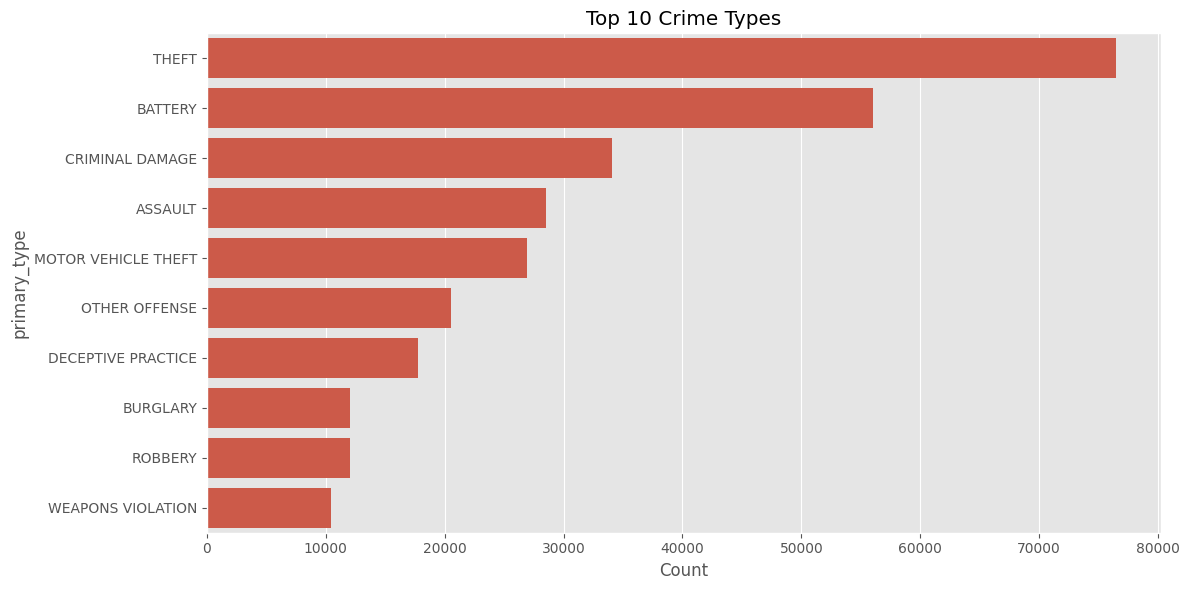

In [181]:
if __name__ == "__main__":
    # Set pandas display options for better output
    pd.set_option('display.max_columns', 50)
    pd.set_option('display.max_rows', 20)

    # Adjust configuration parameters if needed
    CONFIG.max_crime_records = 1000000  # Limit to 1 million for testing
    CONFIG.cache_results = True

    # Create data directory
    os.makedirs(CONFIG.data_dir, exist_ok=True)

    # Execute the pipeline
    final_df = main()

    # Display final summary
    if final_df is not None:
        print("\nFinal Dataset Summary:")
        print(f"Shape: {final_df.shape}")
        print(f"Memory usage: {final_df.memory_usage(deep=True).sum() / (1024**2):.2f} MB")

        # Quick analysis of crime types
        if 'primary_type' in final_df.columns:
            print("\nTop 10 crime types:")
            display(final_df['primary_type'].value_counts().head(10))

            # Create a bar chart of top crime types
            plt.figure(figsize=(12, 6))
            top_crimes = final_df['primary_type'].value_counts().head(10)
            sns.barplot(x=top_crimes.values, y=top_crimes.index)
            plt.title('Top 10 Crime Types')
            plt.xlabel('Count')
            plt.tight_layout()
            plt.show()